<>:7: SyntaxWarning: invalid escape sequence '\('
<>:72: SyntaxWarning: invalid escape sequence '\h'
<>:7: SyntaxWarning: invalid escape sequence '\('
<>:72: SyntaxWarning: invalid escape sequence '\h'
/var/folders/dd/qljtn3m16tbd2k4cpxwmrkk80000gn/T/ipykernel_61325/4244370479.py:7: SyntaxWarning: invalid escape sequence '\('
  \(n\times n\) tensor. The learning pipeline remains the same:
/var/folders/dd/qljtn3m16tbd2k4cpxwmrkk80000gn/T/ipykernel_61325/4244370479.py:72: SyntaxWarning: invalid escape sequence '\h'
  """Return \hat{A} (symmetrically normalized adjacency) in sparse COO format."""


Loaded 203,769 transactions.  Class counts:
 class
unknown    157205
licit       42019
illicit      4545
Name: count, dtype: int64


Reading edges: 100%|██████████| 234355/234355 [00:00<00:00, 1779041.69it/s]

Total edges (including self-loops): 672,479
Index tensor shape: torch.Size([2, 672479])
Sample indices (first 10):
  Row indices: [0, 5260, 5259, 5258, 5257, 5256, 5255, 5254, 5253, 5252]
  Col indices: [5260, 0, 5258, 5259, 5256, 5257, 5254, 5255, 5252, 5253]


Unique edges: 672,479


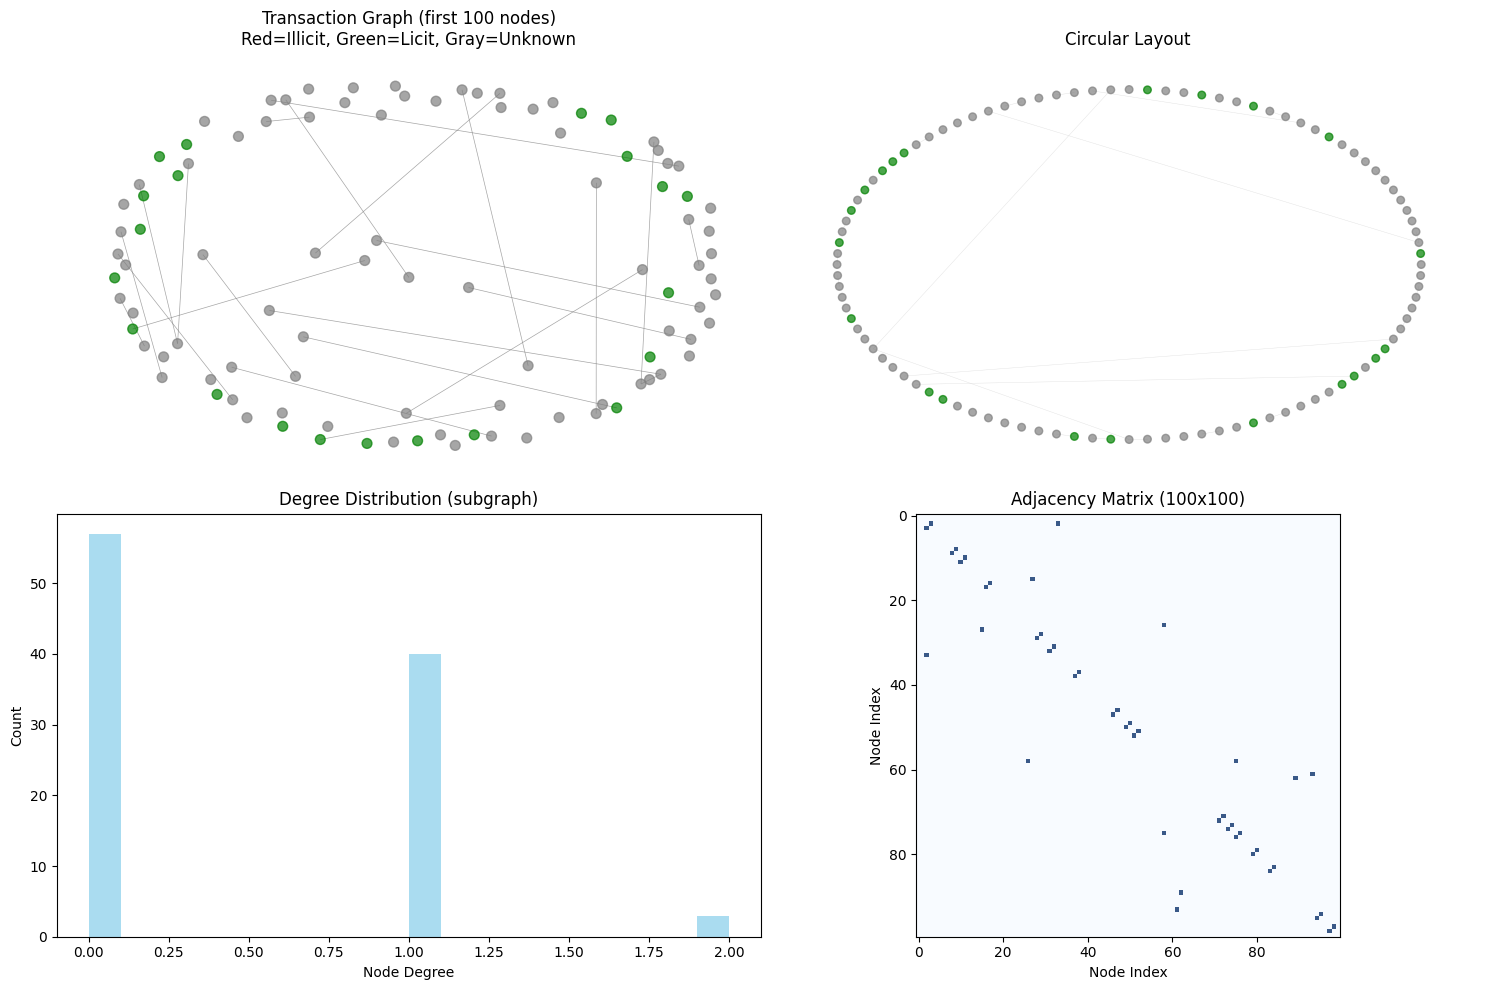

Training Sparse GCN …
Epoch 020  Loss 0.3430
Epoch 040  Loss 0.2780
Epoch 060  Loss 0.2477
Epoch 080  Loss 0.2228
Epoch 100  Loss 0.2044
Finished in 35.7s
Training Random-Forest …
  done in 0.8s
              precision    recall  f1-score   support

       Licit       0.98      1.00      0.99     15587
     Illicit       0.95      0.71      0.81      1083

    accuracy                           0.98     16670
   macro avg       0.97      0.85      0.90     16670
weighted avg       0.98      0.98      0.98     16670

Illicit F1: 0.8116402116402116


In [1]:
# solution_sparse_gcn.py
"""
Sparse GCN + Random-Forest (AF + NE)
====================================
Re-implementation of option5_rf.py that builds the adjacency matrix in
COO (sparse) format to avoid the out-of-memory issue caused by a dense
\(n\times n\) tensor. The learning pipeline remains the same:
1. Load & preprocess Elliptic data.
2. Train a 2-layer GCN on the transaction graph (licit vs illicit).
3. Extract the hidden layer as node embeddings.
4. Concatenate embeddings to the engineered features and fit a Random
   Forest
"""
from __future__ import annotations

import time
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

SEED = 42

import os, random

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True   # 100 % repeatable
torch.backends.cudnn.benchmark = False      # 〃  (slower, but reproducible)

os.environ["PYTHONHASHSEED"] = str(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------------------
# 1. Data loading helpers
# ---------------------------------------------------------------------------

def load_elliptic() -> tuple[pd.DataFrame, pd.DataFrame]:
    """Load CSV files and merge features & labels."""
    features_df = pd.read_csv( "data/elliptic_txs_features.csv", header=None)
    edge_df = pd.read_csv( "data/elliptic_txs_edgelist.csv")
    classes_df = pd.read_csv( "data/elliptic_txs_classes.csv")

    features_df.columns = (
        ["txId", "timestep"]
        + [f"local_feat_{i}" for i in range(93)]
        + [f"agg_feat_{i}" for i in range(72)]
    )

    classes_df["class"] = classes_df["class"].map({"1": "illicit", "2": "licit", "unknown": "unknown"})

    df = pd.merge(features_df, classes_df, on="txId", how="left").sort_values("timestep").reset_index(drop=True)

    return df, edge_df

# ---------------------------------------------------------------------------
# 2. Sparse adjacency utilities
# ---------------------------------------------------------------------------

def build_normalized_adj(df: pd.DataFrame, edge_df: pd.DataFrame) -> torch.sparse.FloatTensor:
    """Return \hat{A} (symmetrically normalized adjacency) in sparse COO format."""
    n = len(df)
    # Map txId to row index
    idx_map = {tx: i for i, tx in enumerate(df["txId"].values)}

    # Build edge index list (adding self-loops later)
    rows: list[int] = []
    cols: list[int] = []

    for src, dst in tqdm(edge_df.itertuples(index=False), desc="Reading edges", total=len(edge_df)):
        src_idx = idx_map.get(src)
        dst_idx = idx_map.get(dst)
        if src_idx is None or dst_idx is None:
            continue
        rows += [src_idx, dst_idx]
        cols += [dst_idx, src_idx]  # make undirected

    # Self-loops
    self_loops = list(range(n))
    rows += self_loops
    cols += self_loops

    indices = torch.tensor([rows, cols], dtype=torch.int64)

    # VISUALIZATION CODE - Add this section
    print(f"Total edges (including self-loops): {indices.shape[1]:,}")
    print(f"Index tensor shape: {indices.shape}")
    print(f"Sample indices (first 10):")
    print(f"  Row indices: {indices[0][:10].tolist()}")
    print(f"  Col indices: {indices[1][:10].tolist()}")
    
    # Check for unique edges
    unique_edges = len(set(zip(indices[0].tolist(), indices[1].tolist())))
    print(f"Unique edges: {unique_edges:,}")


    # # ADD GRAPH VISUALIZATION
    import networkx as nx
    import matplotlib.pyplot as plt
    
    # Create a subgraph for visualization (too large otherwise)
    max_nodes = 100  # Visualize only first 100 nodes
    G = nx.Graph()
    
    # Add nodes
    for i in range(min(max_nodes, n)):
        node_class = df.iloc[i]['class']
        G.add_node(i, node_class=node_class)
    
    # Add edges (only between the first max_nodes)
    edge_count = 0
    for i in range(len(rows)):
        if rows[i] < max_nodes and cols[i] < max_nodes and rows[i] != cols[i]:  # Skip self-loops for clarity
            G.add_edge(rows[i], cols[i])
            edge_count += 1
            if edge_count > 200:  # Limit edges for readability
                break
    
    # Create graph layout and visualization
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Force-directed layout
    plt.subplot(2, 2, 1)
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Color nodes by class
    node_colors = []
    for node in G.nodes():
        node_class = G.nodes[node].get('node_class', 'unknown')
        if node_class == 'illicit':
            node_colors.append('red')
        elif node_class == 'licit':
            node_colors.append('green')
        else:
            node_colors.append('gray')
    
    nx.draw(G, pos, node_color=node_colors, node_size=50, alpha=0.7, 
            with_labels=False, edge_color='grey', width=0.5)
    plt.title(f'Transaction Graph (first {max_nodes} nodes)\nRed=Illicit, Green=Licit, Gray=Unknown')
    
    # Subplot 2: Circular layout
    plt.subplot(2, 2, 2)
    pos_circular = nx.circular_layout(G)
    nx.draw(G, pos_circular, node_color=node_colors, node_size=30, alpha=0.7,
            with_labels=False, edge_color='lightgray', width=0.3)
    plt.title('Circular Layout')
    
    # Subplot 3: Degree distribution
    plt.subplot(2, 2, 3)
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins=20, alpha=0.7, color='skyblue')
    plt.xlabel('Node Degree')
    plt.ylabel('Count')
    plt.title('Degree Distribution (subgraph)')
    
    # Subplot 4: Adjacency matrix heatmap
    plt.subplot(2, 2, 4)
    adj_matrix = nx.adjacency_matrix(G).todense()
    plt.imshow(adj_matrix, cmap='Blues', alpha=0.8)
    plt.title(f'Adjacency Matrix ({max_nodes}x{max_nodes})')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    
    plt.tight_layout()
    plt.show()
    
    # # Print graph statistics
    # print(f"\nGraph Statistics (subgraph of {max_nodes} nodes):")
    # print(f"  Nodes: {G.number_of_nodes()}")
    # print(f"  Edges: {G.number_of_edges()}")
    # print(f"  Connected components: {nx.number_connected_components(G)}")
    # if G.number_of_edges() > 0:
    #     print(f"  Average clustering: {nx.average_clustering(G):.3f}")
    #     print(f"  Density: {nx.density(G):.3f}")

    # Compute normalization coefficients
    deg = torch.bincount(indices[0], minlength=n).float()
    deg_inv_sqrt = torch.pow(deg, -0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    values = deg_inv_sqrt[indices[0]] * deg_inv_sqrt[indices[1]]

    adj = torch.sparse_coo_tensor(indices, values, (n, n))


    return adj

# ---------------------------------------------------------------------------
# 3. GCN model that accepts sparse adj
# ---------------------------------------------------------------------------
class SparseGCN(nn.Module):
    def __init__(self, n_features: int, n_hidden: int, n_classes: int, dropout: float = 0.5):
        super().__init__()
        self.lin1 = nn.Linear(n_features, n_hidden, bias=False)
        self.lin2 = nn.Linear(n_hidden, n_classes, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, adj: torch.sparse.FloatTensor):
        x = torch.spmm(adj, x)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = torch.spmm(adj, x)
        logits = self.lin2(x)
        return logits, x  # Return hidden representation as embedding

# ---------------------------------------------------------------------------
# 4. Training + embedding generation
# ---------------------------------------------------------------------------

def train_gcn(df: pd.DataFrame, adj: torch.sparse.FloatTensor, *, hidden: int = 100, epochs: int = 100) -> np.ndarray:
    label_map = {"licit": 0, "illicit": 1, "unknown": 2}
    labels = torch.tensor(df["class"].map(label_map).values, dtype=torch.long, device=DEVICE)

    features = df.iloc[:, 2:167].values.astype(np.float32)
    features = StandardScaler().fit_transform(features)
    x = torch.tensor(features, device=DEVICE)

    model = SparseGCN(n_features=x.shape[1], n_hidden=hidden, n_classes=2).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    class_weights = torch.tensor([0.3, 0.7], device=DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    train_mask_np = ((df["timestep"] <= 34) & (df["class"] != "unknown")).values
    train_mask = torch.tensor(train_mask_np, dtype=torch.bool, device=DEVICE)

    print("Training Sparse GCN …")
    start = time.time()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out, _ = model(x, adj)
        loss = criterion(out[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:03d}  Loss {loss.item():.4f}")
    print(f"Finished in {time.time() - start:.1f}s")

    model.eval()
    with torch.no_grad():
        _, embeddings = model(x, adj)
    return embeddings.cpu().numpy()

# ---------------------------------------------------------------------------
# 5. Random-Forest evaluation
# ---------------------------------------------------------------------------

def run_random_forest(df: pd.DataFrame, emb: np.ndarray):
    orig = df.iloc[:, 2:167].values.astype(np.float32)
    orig = StandardScaler().fit_transform(orig)
    X = np.concatenate([orig, emb], axis=1)

    y = df["class"].map({"licit": 0, "illicit": 1, "unknown": -1}).values
    train_idx = df[df["timestep"] <= 34].index
    test_idx = df[df["timestep"] > 34].index

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    mask_train = y_train != -1
    mask_test = y_test != -1
    X_train, y_train = X_train[mask_train], y_train[mask_train]
    X_test, y_test = X_test[mask_test], y_test[mask_test]

    clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    print("Training Random-Forest …")
    tic = time.time()
    clf.fit(X_train, y_train)
    print(f"  done in {time.time() - tic:.1f}s")

    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=["Licit", "Illicit"]))
    print("Illicit F1:", f1_score(y_test, y_pred, pos_label=1))


# ---------------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    df, edges = load_elliptic()
    print(f"Loaded {len(df):,} transactions.  Class counts:\n", df["class"].value_counts())

    adj = build_normalized_adj(df, edges).to(DEVICE)
    embeddings = train_gcn(df, adj)
    run_random_forest(df, embeddings)

    # ADDITIONAL VISUALIZATIONS
    # (Uncomment to run visualizations; may increase runtime significantly)
   
